In [299]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.model_selection import train_test_split
import plotly.express as px
import seaborn as sns

import statsmodels.api as sm
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

url = r"C:\Users\urvi9\Downloads\Sales_Count.csv"
df = pd.read_csv(url)
df

,Year,Month,New,Used,Total Sales New,Total Sales Used
0,2002,JAN,31106,49927,755015820,386481929
1,2002,FEB,27520,50982,664454223,361353242
2,2002,MAR,34225,58794,805666244,419385387
3,2002,APR,36452,59817,846368297,433061150
4,2002,MAY,37359,60577,855005784,442569410
...,...,...,...,...,...,...
259,2023,AUG,25876,52725,1222581892,908454060
260,2023,SEP,23892,45386,1134437699,744676584
261,2023,OCT,23775,45473,1122680147,740582533
262,2023,NOV,22720,42260,1062465105,694190564


In [300]:
df.describe()

,Year,New,Used,Total Sales New,Total Sales Used
count,264.000000,264.000000,264.000000,2.640000e+02,2.640000e+02
mean,2012.500000,28127.643939,55426.602273,8.681067e+08,5.587321e+08
std,6.356339,5706.437162,7706.678721,1.715362e+08,1.525242e+08
min,2002.000000,13700.000000,29420.000000,4.051891e+08,2.955220e+08
25%,2007.000000,23848.500000,50090.750000,7.466069e+08,4.395213e+08
50%,2012.500000,27718.500000,55983.500000,8.883341e+08,5.140906e+08
75%,2018.000000,31473.250000,61022.000000,9.860432e+08,6.919647e+08
max,2023.000000,45547.000000,73163.000000,1.295820e+09,9.347858e+08


In [301]:
df['Date'] = pd.to_datetime(df['Year '].astype(str) + '-' + df['Month '], format='%Y-%b')
df.drop(columns=['Year ', 'Month '], inplace=True)

# Set index to month-end instead of month-start
df.set_index('Date', inplace=True)
df.index = df.index + pd.offsets.MonthEnd(0)  # Adjust to end of month
df.index.freq = 'M'  # Set frequency to month-end

df.head()

C:\Users\urvi9\AppData\Local\Temp\ipykernel_18376\1865930630.py:7: FutureWarning:

'M' is deprecated and will be removed in a future version, please use 'ME' instead.



,New,Used,Total Sales New,Total Sales Used
Date,,,,
2002-01-31,31106,49927,755015820,386481929
2002-02-28,27520,50982,664454223,361353242
2002-03-31,34225,58794,805666244,419385387
2002-04-30,36452,59817,846368297,433061150
2002-05-31,37359,60577,855005784,442569410


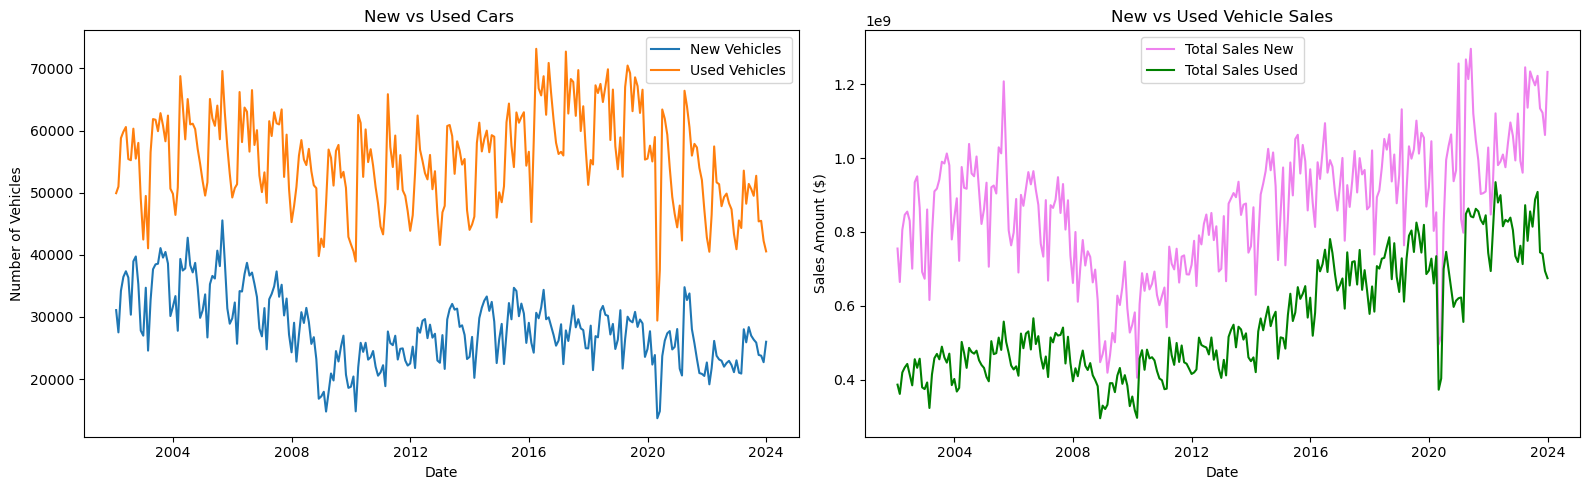

In [302]:
#EDA

fig, axes = plt.subplots(1, 2, figsize=(16, 5), sharex=True)
# Plot 1: New vs Used Cars
axes[0].plot(df.index, df['New'], label='New Vehicles')
axes[0].plot(df.index, df['Used'], label='Used Vehicles')
axes[0].set_title('New vs Used Cars ')
axes[0].set_xlabel('Date')
axes[0].set_ylabel('Number of Vehicles')
axes[0].legend()

# Plot 2: Total Sales New vs Total Sales Used
axes[1].plot(df.index, df['Total Sales New'], label='Total Sales New', color='violet')
axes[1].plot(df.index, df['Total Sales Used'], label='Total Sales Used', color='green')
axes[1].set_title('New vs Used Vehicle Sales')
axes[1].set_xlabel('Date')
axes[1].set_ylabel('Sales Amount ($)')
axes[1].legend()
plt.tight_layout()
plt.show()


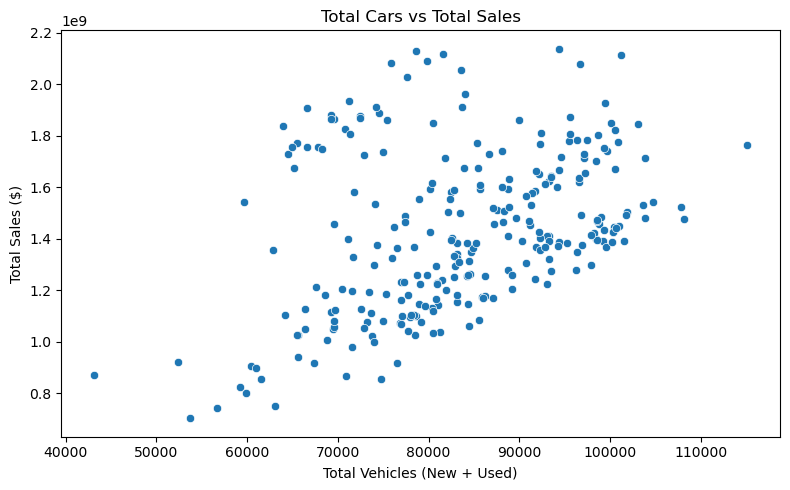

In [303]:
#Scatter Plot: Number of Cars vs Total Sales
plt.figure(figsize=(8, 5))
sns.scatterplot(x=df['New'] + df['Used'], y=df['Total Sales New'] + df['Total Sales Used'])
plt.title('Total Cars vs Total Sales')
plt.xlabel('Total Vehicles (New + Used)')
plt.ylabel('Total Sales ($)')
plt.tight_layout()
plt.show()

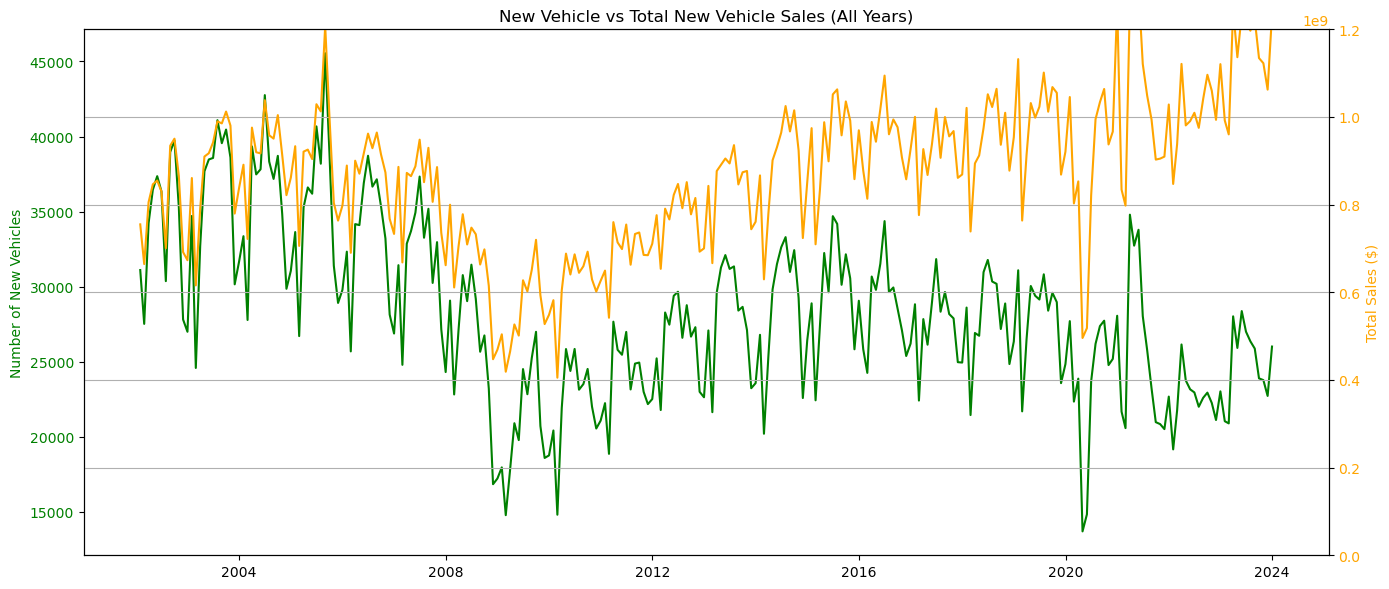

In [304]:
fig, ax1 = plt.subplots(figsize=(14, 6))
ax1.plot(df.index, df['New'], color='green', label='New Vehicles')
ax1.set_ylabel('Number of New Vehicles', color='green')
ax1.tick_params(axis='y', labelcolor='green')

ax2 = ax1.twinx()
ax2.plot(df.index, df['Total Sales New'], color='orange', label='Total Sales New')
ax2.set_ylabel('Total Sales ($)', color='orange')
ax2.tick_params(axis='y', labelcolor='orange')
ax2.set_ylim(0, 1.2e9)  # Set max sales Y limit if needed

plt.title('New Vehicle vs Total New Vehicle Sales (All Years)')
fig.tight_layout()
plt.grid(True)
plt.show()


The difference indicates that over the years, the sales price of new cars increases. 

In [305]:
df.columns = df.columns.str.strip()
df['Year'] = df.index.year
df['Month'] = df.index.strftime('%b').str.upper()  # Converts to JAN, FEB, etc.

def plot_sales_trends(Sales_Type='New', Months=None):
    if Months is None:
        filtered_df = df
    else:
        selected_months = [month for month, selected in Months.items() if selected]
        filtered_df = df[df['Month'].isin(selected_months)]
    
    fig = px.line(
        filtered_df,
        x='Year',
        y=Sales_Type,
        color='Month',
        title=f'{Sales_Type} Vehicle Sales Trends by Month',
        labels={'Year': 'Year', Sales_Type: 'Sales Count ($ or Units)'}
    )
    fig.show()

plot_sales_trends(
    Sales_Type='Total Sales New',
    Months={m: True for m in ['JAN', 'FEB', 'MAR', 'APR', 'MAY', 'JUN', 'JUL', 'AUG', 'SEP', 'OCT', 'NOV', 'DEC']}
)

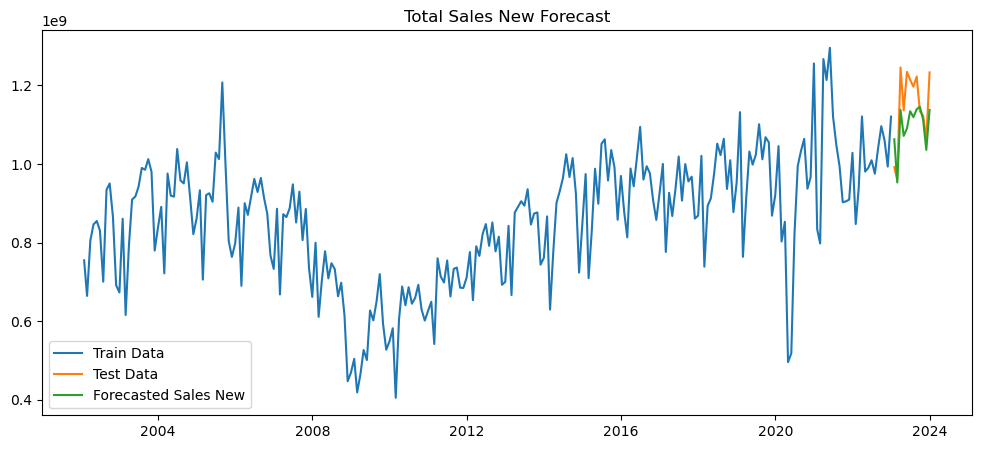

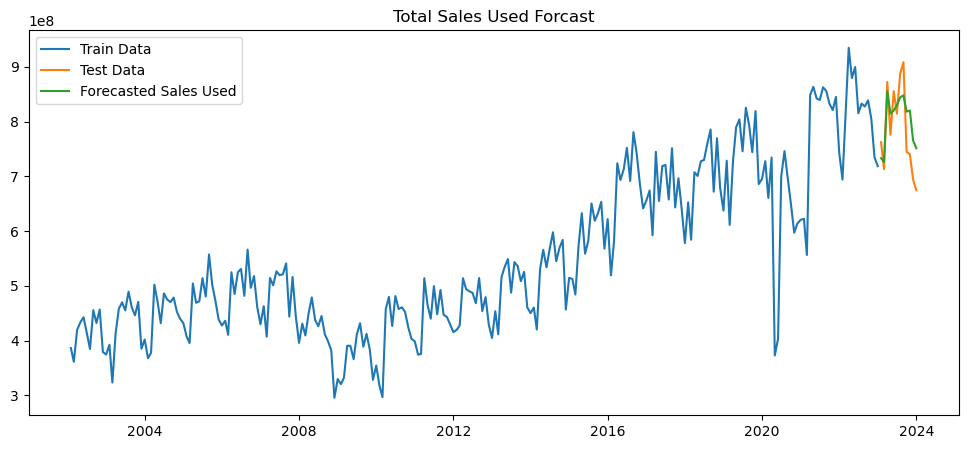

In [306]:
#Time Series Analysis

train_data = df.iloc[:-12] 
test_data = df.iloc[-12:]

model_sales_new = SARIMAX(train_data['Total Sales New'], order=(1,1,1), seasonal_order=(1,1,1,12))
model_sales_used = SARIMAX(train_data['Total Sales Used'], order=(1,1,1), seasonal_order=(1,1,1,12))
results_sales_new = model_sales_new.fit()
results_sales_used = model_sales_used.fit()
forecast_sales_new = results_sales_new.get_forecast(steps=12)
forecast_sales_used = results_sales_used.get_forecast(steps=12)

predicted_sales_new = forecast_sales_new.predicted_mean
predicted_sales_used = forecast_sales_used.predicted_mean

plt.figure(figsize=(12,5))
plt.plot(train_data.index, train_data['Total Sales New'], label='Train Data')
plt.plot(test_data.index, test_data['Total Sales New'], label='Test Data')
plt.plot(test_data.index, predicted_sales_new, label='Forecasted Sales New')
plt.legend()
plt.title('Total Sales New Forecast')
plt.show()

plt.figure(figsize=(12,5))
plt.plot(train_data.index, train_data['Total Sales Used'], label='Train Data')
plt.plot(test_data.index, test_data['Total Sales Used'], label='Test Data')
plt.plot(test_data.index, predicted_sales_used, label='Forecasted Sales Used')
plt.legend()
plt.title('Total Sales Used Forcast')
plt.show()


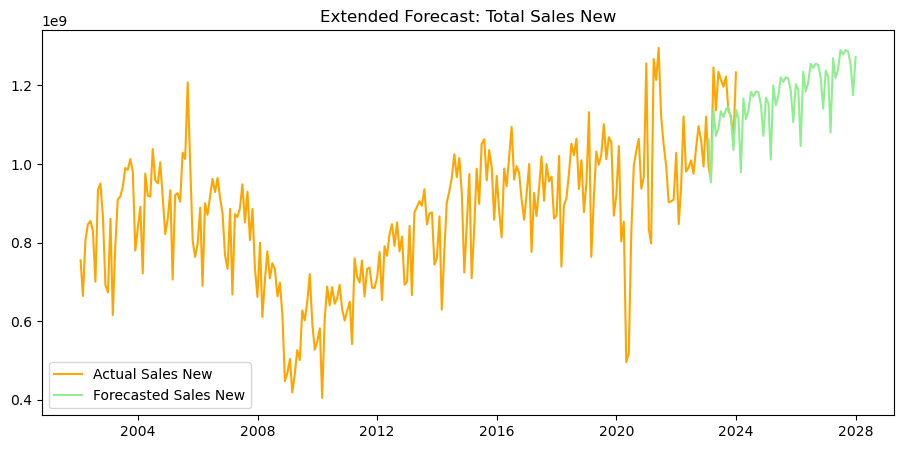

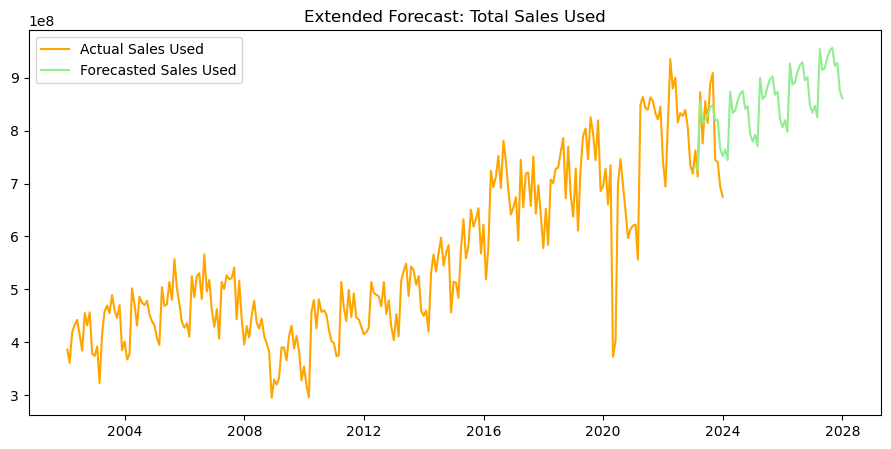

In [307]:
steps = 60 #(60 months)
forecast_sales_new_extended = results_sales_new.get_forecast(steps=steps)
forecast_sales_used_extended = results_sales_used.get_forecast(steps=steps)
predicted_sales_new_extended = forecast_sales_new_extended.predicted_mean
predicted_sales_used_extended = forecast_sales_used_extended.predicted_mean

plt.figure(figsize=(11,5))
plt.plot(df.index, df['Total Sales New'], label='Actual Sales New',color='orange')
plt.plot(predicted_sales_new_extended.index, predicted_sales_new_extended, label='Forecasted Sales New',color='lightgreen')
plt.legend()
plt.title('Extended Forecast: Total Sales New')
plt.show()

plt.figure(figsize=(11,5))
plt.plot(df.index, df['Total Sales Used'], label='Actual Sales Used',color='orange')
plt.plot(predicted_sales_used_extended.index, predicted_sales_used_extended, label='Forecasted Sales Used',color='lightgreen')
plt.legend()
plt.title('Extended Forecast: Total Sales Used')
plt.show()

05:49:08 - cmdstanpy - INFO - Chain [1] start processing
05:49:09 - cmdstanpy - INFO - Chain [1] done processing


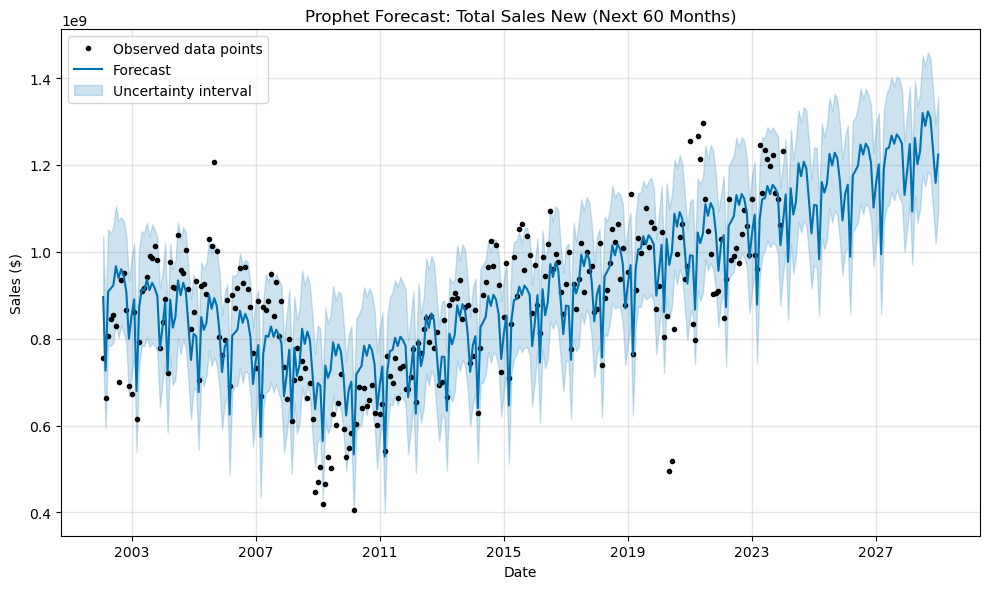

In [308]:
from prophet import Prophet
import pandas as pd
import matplotlib.pyplot as plt
df_prophet = df[['Total Sales New']].reset_index().rename(columns={'Date': 'ds', 'Total Sales New': 'y'})
model = Prophet()
model.fit(df_prophet)

#60 months 
future = model.make_future_dataframe(periods=60, freq='ME')  # Use 'ME' for month-end
forecast = model.predict(future)

fig = model.plot(forecast)
plt.title('Prophet Forecast: Total Sales New (Next 60 Months)')
plt.xlabel('Date')
plt.ylabel('Sales ($)')
plt.tight_layout()
plt.legend()
plt.show()


In [309]:
df_prophet = df[['Total Sales New']].reset_index().rename(columns={'Date': 'ds', 'Total Sales New': 'y'})
test_prophet = df_prophet.iloc[-12:]
forecast_test = forecast.set_index('ds').loc[test_prophet['ds'], 'yhat']

mae_prophet = mean_absolute_error(test_prophet['y'], forecast_test)
mse_prophet = mean_squared_error(test_prophet['y'], forecast_test)

mae_sarimax = mean_absolute_error(test_data['Total Sales New'], predicted_sales_new)
mse_sarimax = mean_squared_error(test_data['Total Sales New'], predicted_sales_new)

comparison_df = pd.DataFrame({
    'Model': ['SARIMAX', 'Prophet'],
    'MAE': [mae_sarimax, mae_prophet],
    'MSE': [mse_sarimax, mse_prophet]
})
comparison_df


,Model,MAE,MSE
0,SARIMAX,6.491477e+07,5.920966e+15
1,Prophet,7.498864e+07,8.249400e+15


SARIMAX demonstrated superior forecasting accuracy compared to Prophet, with significantly lower error metrics (MAE and MSE), making it the more reliable model for predicting future new vehicle sales.

e:\AnacondaNavigator\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.



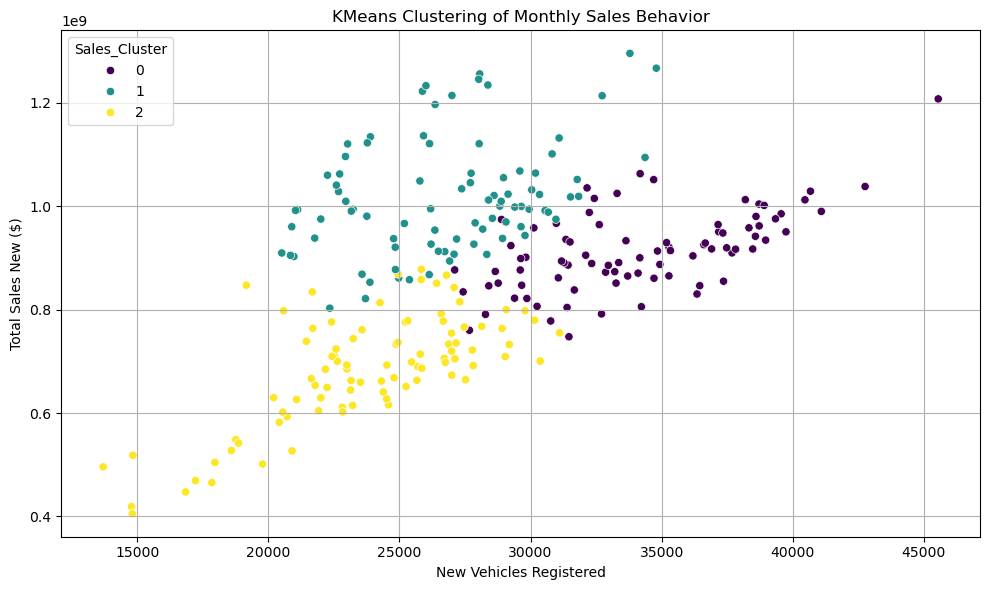

In [310]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
features = df[['New', 'Used', 'Total Sales New', 'Total Sales Used']]  # or add GDP if present

scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)
kmeans = KMeans(n_clusters=3, random_state=42)
clusters = kmeans.fit_predict(scaled_features)

df['Sales_Cluster'] = clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='New', y='Total Sales New', hue='Sales_Cluster', palette='viridis')
plt.title('KMeans Clustering of Monthly Sales Behavior')
plt.xlabel('New Vehicles Registered')
plt.ylabel('Total Sales New ($)')
plt.grid(True)
plt.tight_layout()
plt.show()


Insight:
Cluster 0 (purple) shows high volume and revenue — best for early inventory and marketing. Cluster 1 (teal) has strong revenue with moderate volume, suggesting premium sales potential. Cluster 2 (yellow) reflects low performance, warranting a review of demand or supply issues.

In [311]:
#Feature Engineering

df_fe = df.copy()
df_fe.index.freq = 'ME'

df_fe['Month'] = df_fe.index.month
df_fe['Quarter'] = df_fe.index.quarter
df_fe['YoY_Sales_New'] = df_fe['Total Sales New'].pct_change(12) * 100
df_fe['YoY_Sales_Used'] = df_fe['Total Sales Used'].pct_change(12) * 100

df_fe['Lag_1_Sales_New'] = df_fe['Total Sales New'].shift(1)
df_fe['Lag_1_Sales_Used'] = df_fe['Total Sales Used'].shift(1)

df_fe['Rolling_3_Sales_New'] = df_fe['Total Sales New'].rolling(window=3).mean()
df_fe['Rolling_3_Sales_Used'] = df_fe['Total Sales Used'].rolling(window=3).mean()

# Preview
df_fe.tail()

,New,Used,Total Sales New,Total Sales Used,Year,Month,Sales_Cluster,Quarter,YoY_Sales_New,YoY_Sales_Used,Lag_1_Sales_New,Lag_1_Sales_Used,Rolling_3_Sales_New,Rolling_3_Sales_Used
Date,,,,,,,,,,,,,,
2023-08-31,25876,52725,1222581892,908454060,2023,8,1,3,17.464421,9.775997,1.196918e+09,887723892.0,1.211280e+09,8.701513e+08
2023-09-30,23892,45386,1134437699,744676584,2023,9,1,3,3.476935,-11.217752,1.222582e+09,908454060.0,1.184646e+09,8.469515e+08
2023-10-31,23775,45473,1122680147,740582533,2023,10,1,4,5.904045,-7.979921,1.134438e+09,744676584.0,1.159900e+09,7.979044e+08
2023-11-30,22720,42260,1062465105,694190564,2023,11,1,4,6.938269,-5.517577,1.122680e+09,740582533.0,1.106528e+09,7.264832e+08
2023-12-31,26010,40556,1233234965,674734577,2023,12,1,4,10.052582,-6.097155,1.062465e+09,694190564.0,1.139460e+09,7.031692e+08


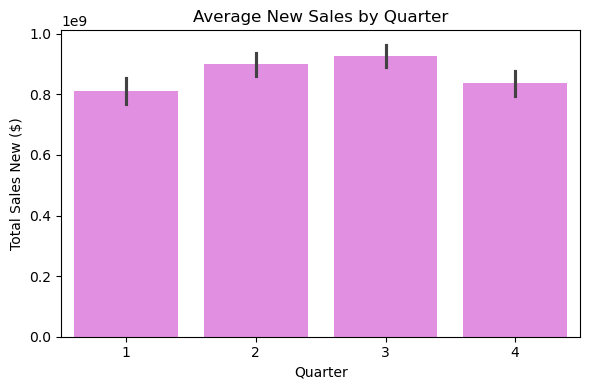

In [312]:
plt.figure(figsize=(6, 4))
sns.barplot(x='Quarter', y='Total Sales New', data=df_fe, color='violet')
plt.title('Average New Sales by Quarter')
plt.ylabel('Total Sales New ($)')
plt.xlabel('Quarter')
plt.tight_layout()
plt.show()


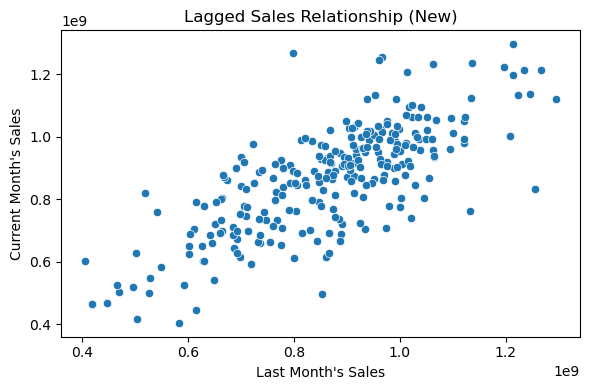

In [313]:
plt.figure(figsize=(6, 4))
sns.scatterplot(x='Lag_1_Sales_New', y='Total Sales New', data=df_fe)
plt.title('Lagged Sales Relationship (New)')
plt.xlabel('Last Month\'s Sales')
plt.ylabel('Current Month\'s Sales')
plt.tight_layout()
plt.show()


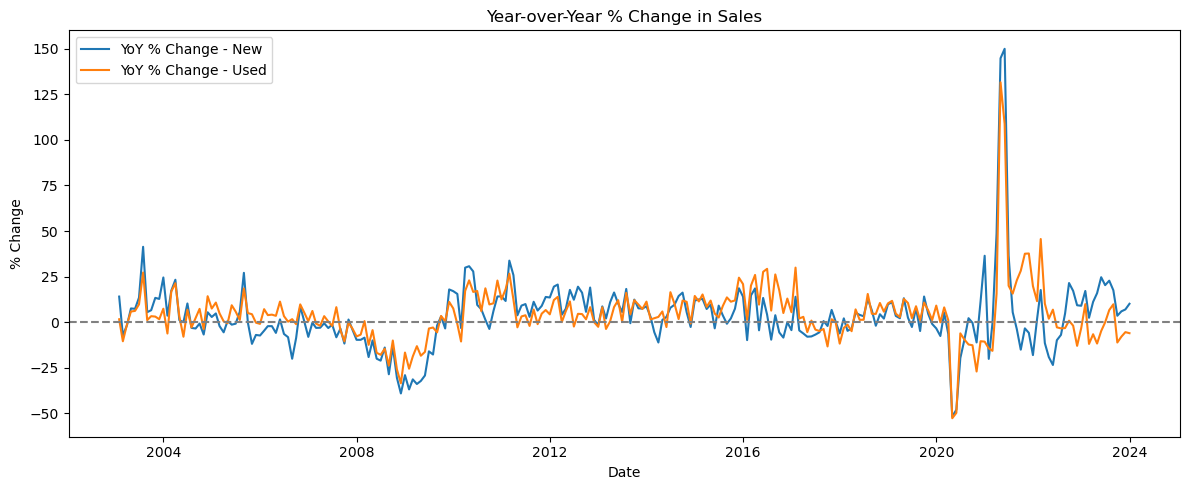

In [314]:
plt.figure(figsize=(12, 5))
plt.plot(df_fe.index, df_fe['YoY_Sales_New'], label='YoY % Change - New')
plt.plot(df_fe.index, df_fe['YoY_Sales_Used'], label='YoY % Change - Used')
plt.axhline(0, color='gray', linestyle='--')
plt.title('Year-over-Year % Change in Sales')
plt.xlabel('Date')
plt.ylabel('% Change')
plt.legend()
plt.tight_layout()
plt.show()
